In [4]:
# adding scritps to path
import sys
sys.path.insert(1, '/mnt/c/Users/john/OneDrive - University of Toronto/software/sliding_twin')

In [5]:
# dependencies
import os
import numpy as np
import nilearn as nl
import nibabel as nib
import scipy.io as sio
import slide_twin as twin # mine
from math import prod
from importlib import reload
from matplotlib.pyplot import plot
from scipy.signal import argrelextrema, find_peaks
from nilearn.input_data import NiftiLabelsMasker

In [6]:
# reload modules
reload(twin)

<module 'slide_twin' from '/mnt/c/Users/john/OneDrive - University of Toronto/software/sliding_twin/slide_twin.py'>

# Gathering Time Windows

In [7]:
win=20
step=1

In [8]:
input_path = "/mnt/c/Users/john/OneDrive - University of Toronto/software/preprocessing/input.txt"
input_data = np.genfromtxt(input_path, delimiter=',', dtype=str)

In [9]:
atlas_mask = "/mnt/c/Users/john/Desktop/craddock_2012/t20.nii.gz"

In [ ]:
for count, subj in enumerate(input_data, start=1):
    os.makedirs(os.path.join(subj, "sliding_timewindows"), exist_ok=True)

    nii_path = os.path.join(subj, "func", "scrub_nuis_nl_m_t_func.nii.gz")
    roi_path = os.path.join(subj, "sliding_timewindows", "roi_tcourses.csv")
    twin_path= os.path.join(subj, "sliding_timewindows", "roi_twin.mat")

    masker = NiftiLabelsMasker(labels_img=atlas_mask, standardize=False)
    tcourses= masker.fit_transform(nii_path)

    fc_mats, twindows = twin.sliding_twin(tcourses, win, step, twin_path)

    fc_var = np.asanyarray([np.nanvar(fc_mats[:,:,X]) for X in range(fc_mats.shape[2])])
    local_max = np.transpose(argrelextrema(fc_var, np.greater))

    lmax_path = os.path.join(subj, "sliding_timewindows", "var_localmax.csv")
    np.savetxt(lmax_path, local_max.astype(int), fmt='%i', delimiter=",")
    print(str(count), "/", str(len(input_data)))

# Finding high-variance FC matrices across all partipants

In [10]:
for count, subj in enumerate(input_data, start=1):
    fc_path = os.path.join(subj, "sliding_timewindows", "roi_twin.mat")
    fc_dic  = sio.loadmat(fc_path)
    fc_mat  = fc_dic["fc_mats"]

    varpeak_path = os.path.join(subj, "sliding_timewindows", "var_localmax.csv")
    varpeak_ind  = np.genfromtxt(varpeak_path)
    varpeak_ind  = varpeak_ind.astype(int)

    fc_subsamp = fc_mat[:,:,varpeak_ind]

    if count==1:
        subsamp_coll = fc_subsamp
    else:
        subsamp_coll = np.append(subsamp_coll, fc_subsamp, axis=2)

In [11]:
# reshaping into 2D matrix
new_shape = [prod(subsamp_coll.shape[:2]), subsamp_coll.shape[2]]
fcmat_col = np.reshape(subsamp_coll, new_shape, order="F")
fcmat_col = np.transpose(fcmat_col)

In [15]:
fcmat_col = np.nan_to_num(fcmat_col, nan=0.0)

# K-Means Clustering

In [12]:
sys.path.insert(1, '/mnt/c/Users/john/OneDrive - University of Toronto/software/Kmeans')

In [13]:
import kmeans # mine
from nilearn import plotting

In [ ]:
ss_ls = []

for kk in range(1,11):
    _, _, SS_k = kmeans.kmeans(fcmat_col, k=kk, sumsqrs=True)
    ss_ls.append(SS_k)

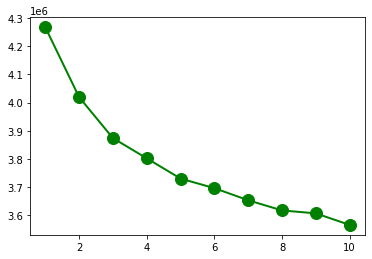

In [17]:
plot(range(1,11), ss_ls, "go-", linewidth=2, markersize=12)

Seem to have the best results when k=8, so we'll go with that.

In [18]:
y_kmeans, km, SS_k = kmeans.kmeans(fcmat_col, k=8, sumsqrs=True)
# y_kmeans is the cluster membership
# km is the kmeans object. Centroids are stored in km.cluster_centers_
# SS_k is the sum of squares error

In [19]:
kcentroids = np.transpose(km.cluster_centers_)

In [20]:
orig_shape    = [199, 199, 8]
re_kcentroids = np.reshape(kcentroids, orig_shape, order="F")

## Plotting the Clusters

In [23]:
for ii in range(re_kcentroids.shape[2]):
    np.fill_diagonal(re_kcentroids[:,:,ii], 0)

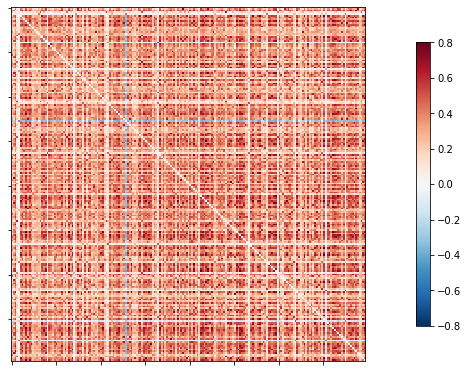

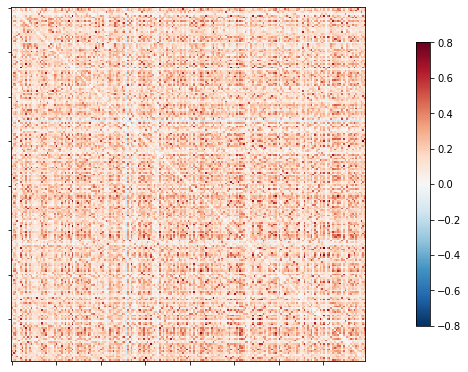

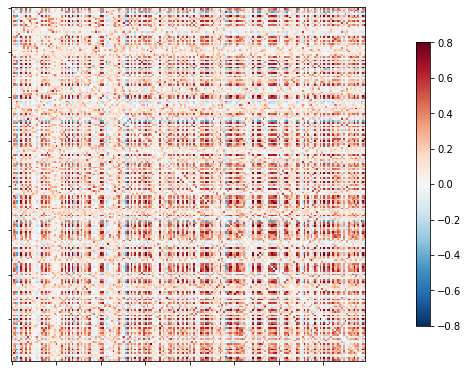

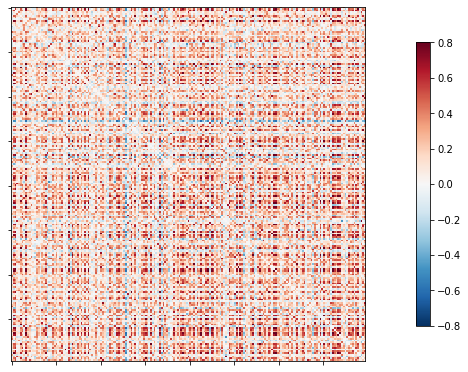

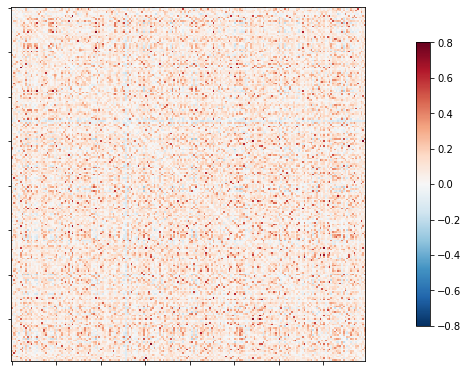

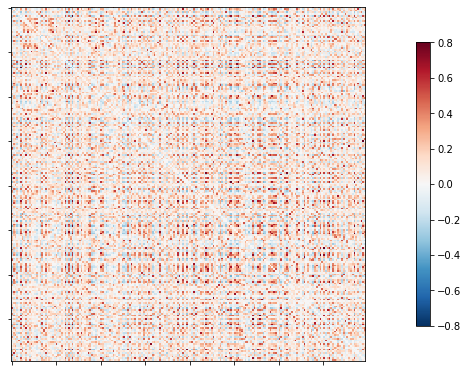

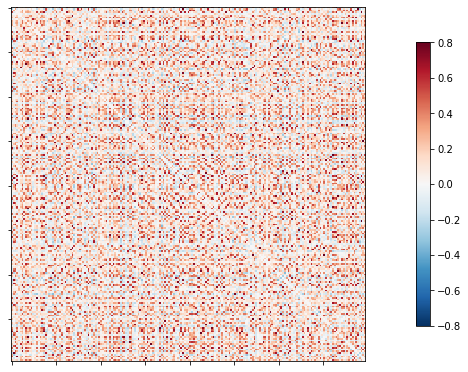

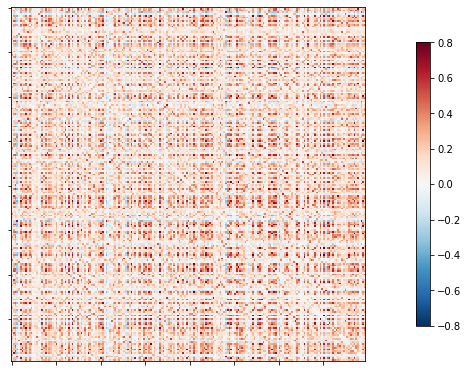

In [25]:
# TODO: Add labels to these.
for ii in range(re_kcentroids.shape[2]):
    plotting.plot_matrix(re_kcentroids[:,:,ii], colorbar=True, 
        vmax=0.8, vmin=-0.8)